This notebook is intended to introduce and demonstrate some of the features of pyMAISE and examine the performance of machine learning models on a common nuclear engineering application. For further information on the capabilities of the classes and functions shown in this notebook, please refer to the [pyMAISE API reference documentation](https://pymaise.readthedocs.io/en/stable/pymaiseapi/index.html).

# MIT Reactor

**Inputs**: Control rod heights ($cm$)

**Outputs**: Pin power ($W$)

The MIT reactor data set represents the institution’s light-water-cooled 6 MW thermal power reactor. The figure below shows the core contains 22 fuel elements, 5 locations for in-core experiments, and six control blades surrounding them. The data set is used to find a relationship between the six control blade heights and the power produced by the 22 fuel elements in the core. Therefore, the data set is constructed by perturbing the depths of the control blades in the reactor—the corresponding output results in the power levels for each of the 22 fuel elements. The data was generated using MCNP, and the data set size includes 1000 simulations/samples [[RPS+23]](https://pymaise.readthedocs.io/en/stable/index.html#id3). The goal is to use pyMAISE to build, tune, and compare the performance of various ML models in predicting the core power distribution based on the control blade insertion depth.

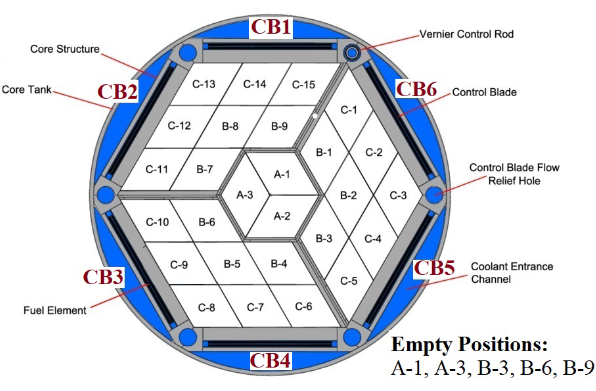

The following are a few standard packages and functions that will prove helpful while using pyMAISE.

In [1]:
%load_ext autoreload
%autoreload 2
#import functions as F

import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
from sklearn.preprocessing import MinMaxScaler

# Plot settings
matplotlib_settings = {
    "font.size": 12,
    "legend.fontsize": 11,
    "figure.figsize": (8, 8)
}
plt.rcParams.update(**matplotlib_settings)

We need to import several functions and classes for machine learning tuning and analysis with pyMAISE. Firstly, we need the MITR data set, which we can get using `pyMAISE.datasets.load_MITR`. We must split the data into training/testing data and scale it. For this, we use the `pyMAISE.preprocessing` Python module. The remaining classes we can get from `pyMAISE` directly which we import as `mai` for convenience.

In [2]:
from pyMAISE.datasets import load_MITR
from pyMAISE.preprocessing import correlation_matrix, train_test_split, scale_data
import pyMAISE as mai

## pyMAISE Initialization

Starting any pyMAISE job requires initialization. This includes the definition of global settings used throughout pyMAISE. These settings and their defaults include:

- `problem_type`: the problem type, either regression or classification, defined by `pyMAISE.ProblemType`,
- `verbosity=0`: the level of output from pyMAISE,
- `random_state=None`: the seed for the random number generator, which can be used to get reproducible results from pyMAISE,
- `num_configs_saved=5`: the number of top hyperparameter configurations for each model evaluated during tuning,
- `new_nn_architecture=True`: a boolean that dictates whether to use the old deprecated pyMAISE neural network tuning architecture,
- `cuda_visible_devices=None`: sets the `CUDA_VISIBLE_DEVICES` environment variable.

The only argument that needs to be specified is `problem_type`. We also pass `"-1"` to `cuda_visible_devices` to ensure we only use tensorflow on the CPU. This is useful for this problem since we will build relatively simple, dense feedforward neural networks with a reasonably small data set. Therefore, running tensorflow on a GPU may hurt our performance. We leave the others default, giving us five hyperparameter configurations for each model, keeping the stochastic nature of some of the algorithms, and using the current neural network hyperparameter tuning architecture.

In [3]:
global_settings = mai.init(
    problem_type=mai.ProblemType.REGRESSION,   # Define a regression problem
    cuda_visible_devices="-1"                  # Use CPU only
)

## Data Loading and Preprocessing

pyMAISE has several benchmarked data sets, such as this MIT reactor data set. Each data set has an accompanying load function. Most load functions return three `xarray.DataArrays`: the raw, input, and output data. You can load personal data using the `pyMAISE.preprocessing.read_csv` function. Refer to the [pyMAISE API reference documentation](https://pymaise.readthedocs.io/en/stable/pymaiseapi/index.html) for specifics on the use of this function. Loading the MIT reactor data gives the following data:

In [4]:
data, inputs, outputs = load_MITR()

The MIT reactor data set has six inputs; one for each control rod position:

In [5]:
inputs

<xarray.DataArray (index: 1000, variable: 6)>
array([[25.95991738, 22.94937226, 20.85317495, 24.66916763, 20.48104739,
        25.35726597],
       [21.75386762, 25.3606259 , 20.58853009, 20.11087249, 27.46711019,
        25.81658492],
       [27.42919944, 23.5701803 , 27.59630663, 26.39044508, 23.99603712,
        24.61182164],
       ...,
       [24.47247392, 23.21393049, 21.36224456, 25.72137934, 21.72606189,
        20.486756  ],
       [25.14502476, 25.88719097, 22.63841745, 23.11818585, 27.13820033,
        20.12257523],
       [20.80736327, 20.47244047, 26.3283514 , 24.93870275, 22.13608868,
        20.23749172]])
Coordinates:
  * index     (index) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * variable  (variable) object 'CR1' 'CR2' 'CR3' 'CR4' 'CR5' 'CR6'

and 22 fuel element power outputs:

In [6]:
outputs

<xarray.DataArray (index: 1000, variable: 22)>
array([[25930.9161377 , 22958.31494141, 21725.51635742, ...,
        17912.01452637, 18207.04260254, 19089.96942139],
       [25883.078125  , 22856.06195068, 21602.10876465, ...,
        18699.55557251, 18381.29052734, 19052.58782959],
       [25672.20825195, 22584.91094971, 21419.95025635, ...,
        17878.91418457, 17831.21044922, 18702.88995361],
       ...,
       [26011.28759766, 22868.43511963, 21718.16387939, ...,
        17537.16012573, 17521.70654297, 18469.28430176],
       [25867.42346191, 22746.65338135, 21650.78973389, ...,
        17898.8989563 , 17467.56048584, 18369.0256958 ],
       [26047.4777832 , 22729.4630127 , 21553.59606934, ...,
        17622.36529541, 17503.63659668, 18324.41955566]])
Coordinates:
  * index     (index) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * variable  (variable) object 'A-2' 'B-1' 'B-2' 'B-4' ... 'C-13' 'C-14' 'C-15'

To get a better understanding of this data set lets plot a correlation matrix of the data using `pyMAISE.preprocessing.correlation_matrix`.

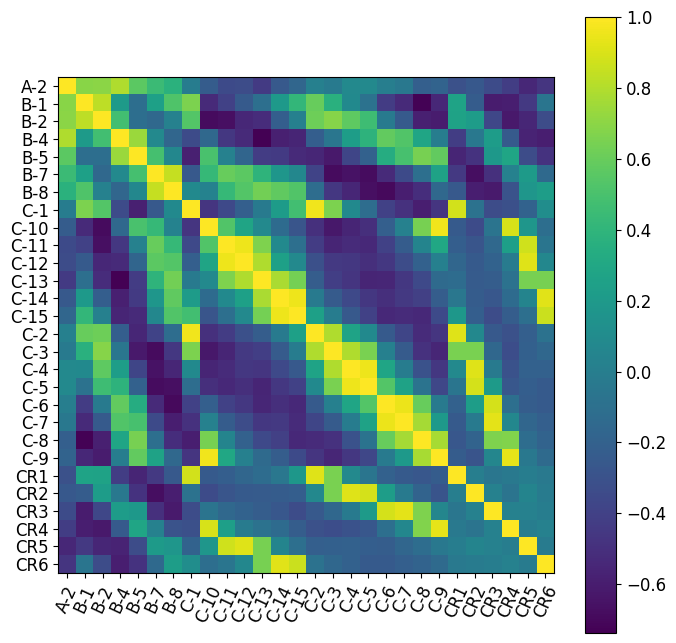

In [7]:
correlation_matrix(data)

plt.show()

A negative correlation exists between the control rod positions and the inner fuel elements (A and B elements).

With the data loaded, we can now preprocess it. This includes splitting into training and testing data sets and scaling. For splitting, we use the `pyMAISE.preprocessing.train_test_split` function and define the fraction of data for testing using `test_size`. On MITR, we take 30% of the data for testing. The result is a tuple of data: `(xtrain, xtest, ytrain, ytest)`. We can then scale this data using `pyMAISE.preprocessing.scale_data` with any object that supports `fit_transform` and `transform` functions. Common scalers include [sklearn.preprocessing.MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) and [sklearn.preprocessing.StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler). Many machine learning models learn best with scaled data. We use min-max scaling on both the input and output data for this data set. `pyMAISE.preprocessing.scale_data` returns the scaled data, and the scaler fits the data. These scalers are used in postprocessing to evaluate the performance of the models.

In [8]:
xtrain, xtest, ytrain, ytest = train_test_split(data=[inputs, outputs], test_size=0.3)
xtrain, xtest, xscaler = scale_data(xtrain, xtest, scaler=MinMaxScaler())
ytrain, ytest, yscaler = scale_data(ytrain, ytest, scaler=MinMaxScaler())

## Model Initialization

For model initialization and tuning, we use the `pyMAISE.Tuner`. pyMAISE supports both classical ML methods with [scikit-learn](https://scikit-learn.org/stable/index.html) and sequential neural networks with [Keras](https://keras.io/). We strongly recommend you refer to `pyMAISE.Tuner` in the [pyMAISE API reference documentation](https://pymaise.readthedocs.io/en/stable/pymaiseapi/index.html) for a list of supported models, neural network layers, and other information crucial for optimal tuning. We can define all the models we wish to hyperparameter tune using a dictionary. For the MITR data set, we define the following regression models with their dictionary keys:

- linear: `"Linear"`,
- lasso: `"Lasso"`,
- decision tree: `"DT"`,
- random forest: `"RF"`,
- k-nearest neighbors: `"KN"`,
- feedforward neural network: `"FNN"`.

pyMAISE uses the dictionary keys for classical models to determine which [scikit-learn](https://scikit-learn.org/stable/index.html) model you request. If the keys do not match any supported keys, then it is assumed to be a neural network. In the `"models"` key, we define these models in a list. We can then define the hyperparameters for classical models, which will remain constant throughout tuning. These parameters must only be defined if you want something different from the default. Refer to the model documentation in [scikit-learn](https://scikit-learn.org/stable/index.html) for hyperparameters and defaults.

For the neural network model, we need to define the architecture, optimizer, compiling, and fitting parameters under the `"structural_params"`, `"optimizer"`, `"compile_params"`, and `"fitting_params"` keys. These parameters include those that remain constant and change during tuning. To define hyperparameters for tuning, we use the `pyMAISE.Int`, `pyMAISE.Float`, `pyMAISE.Choice`, `pyMAISE.Boolean`, and `pyMAISE.Fixed` classes. These classes are wrappers for [KerasTuner](https://keras.io/keras_tuner/). 

To define the model architecture, we use the supported Keras layers defined in the [pyMAISE API reference documentation](https://pymaise.readthedocs.io/en/stable/pymaiseapi/index.html) under the `pyMAISE.Tuner`. These layers must differ in name, but use the base layer name. Within the layers, pyMAISE supports additional hyperparameters, which include `"sublayer"`, `"wrapper"`, and `"num_layers"` to define sublayers, wrappers (such as [keras.layers.TimeDistributed](https://keras.io/api/layers/recurrent_layers/time_distributed/)), and the number of layers.

We can then pass all this information to `pyMAISE.Tuner`.

In [9]:
model_settings = {
    "models": ["Linear", "Lasso", "Stacking", "MultiOutput", "GB", "DT", "FNN", "GP", "RD", "ET", "EN", "AB", "RF", "KN"],
    "FNN": {
        "structural_params": {
            "Dense_hidden": {
                "num_layers": mai.Int(min_value=0, max_value=3),
                "units": mai.Int(min_value=25, max_value=400),
                "activation": "relu",
                "kernel_initializer": "normal",
                "sublayer": mai.Choice(["Dropout_hidden", "None"]),
                "Dropout_hidden": {
                    "rate": mai.Float(min_value=0.4, max_value=0.6),
                },
            },
            "Dense_output": {
                "units": ytrain.shape[-1],
                "activation": "linear",
                "kernel_initializer": "normal",
            },
        },
        "optimizer": "Adam",
        "Adam": {
            "learning_rate": mai.Float(min_value=1e-5, max_value=0.001),
        },
        "compile_params": {
            "loss": "mean_absolute_error",
            "metrics": ["mean_absolute_error"],
        },
        "fitting_params": {
            "batch_size": mai.Choice([8, 16, 32]),
            "epochs": 50,
            "validation_split": 0.15,
        },
    },
    "GB":{
        "multi_output": True  
    },
    "AB":{
        "multi_output": True  
    },
    "MultiOutput":{
        "estimator": "SVM"
    },
    "Stacking":{
        "estimators": ["EN", "GP"],
        "_multi_output": True,
    },
}
tuner = mai.Tuner(xtrain, ytrain, model_settings=model_settings)

## Hyperparameter Tuning

Hyperparameter tuning is split into two options: classical model and neural network tuning. For the classical models, pyMAISE supports grid, random, and Bayesian search. For the neural network models, pyMAISE supports grid, random, Bayesian, and hyperband search. All search methods use cross-validation.

We define the hyperparameter search space for the classical models by defining the arrays, distributions, or [skopt.space.space](https://scikit-optimize.github.io/stable/modules/classes.html#module-skopt.space.space) for each hyperparameter we plan to tune. We describe these within subdictionaries within the model keys. For MITR, we use `pyMAISE.Tuner.random_search` with 200 iterations as the data set is relatively small and the classical models are computationally cheap. For these models, we define the search space using [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html).

We do not hyperparameter tune linear regression because the hyperparameter options are limited, and the default scikit-learn model performs well on linear problems.

Since we have already defined the feedforward neural network search space in the previous section, all we need to do is call the search method function. For these NNs, we can call `pyMAISE.Tuner.nn_bayesian_search` with 50 iterations as NNs tend to be more computationally expensive to train over the classical models, and the Bayesian optimization may converge on the optimal model for fewer iterations.

We set `cv` for both methods to 5, which gives us five cross-validation splits for each model. This will avoid overfitting. Therefore, for each classical model, we run 1000 hyperparameter configurations, and for the neural networks, we run 250 hyperparameter configurations.

In [10]:
random_search_spaces = {
    "Lasso": {
        "alpha": uniform(loc=0.0001, scale=0.0099), # 0.0001 - 0.01
    },
    "DT": {
        "max_depth": randint(low=5, high=50), # 5 - 50
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
    },
    "RF": {
        "n_estimators": randint(low=50, high=200), # 50 - 200
        "criterion": ["squared_error", "absolute_error", "poisson"],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
    },
    "KN": {
        "n_neighbors": randint(low=1, high=20), # 1 - 20
        "weights": ["uniform", "distance"],
        "leaf_size": randint(low=1, high=30), # 1 - 30
        "p": randint(low=1, high=10), # 1 - 10
    },
    "GP":{
        "alpha": uniform(loc=1e-11, scale=1e-9)
    },
    "RD":{
        "alpha": uniform(loc=1e-11, scale=1e-9)
    },
    "EN": {
        "alpha": uniform(loc=1e-11, scale=1e-9)
    },
    "ET":{
        "max_depth": randint(low=5, high=50), # 5 - 50
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
    },
    "GB": {
        "estimator__learning_rate": uniform(loc=0.1, scale=1e-2)
    },
    "AB":{
        "estimator__learning_rate": uniform(loc=1, scale=0.5)
    },
    "MultiOutput":{
        "estimator__C": uniform(loc=0.01, scale=99.99), # 0.01 - 100
    },
    "Stacking":{
        "estimator__EN__alpha": uniform(loc=1e-11, scale=1e-9),
        "estimator__GP__alpha": uniform(loc=1e-11, scale=1e-9),
    },
}
start = time.time()
random_search_configs = tuner.random_search(
    param_spaces=random_search_spaces, 
    n_iter=200,
    n_jobs=6,
    cv=5,
)
bayesian_search_configs = tuner.nn_bayesian_search(
    objective="r2_score",
    max_trials=50,
    cv=5,
)
print("Hyperparameter tuning took " + str((time.time() - start) / 60) + " minutes to process.")

Hyperparameter tuning took 32.74498364130656 minutes to process.


After the training, we can see training results for each iteration using the `pyMAISE.Tuner.convergence_plot` function. For the neural networks, we have the following: 

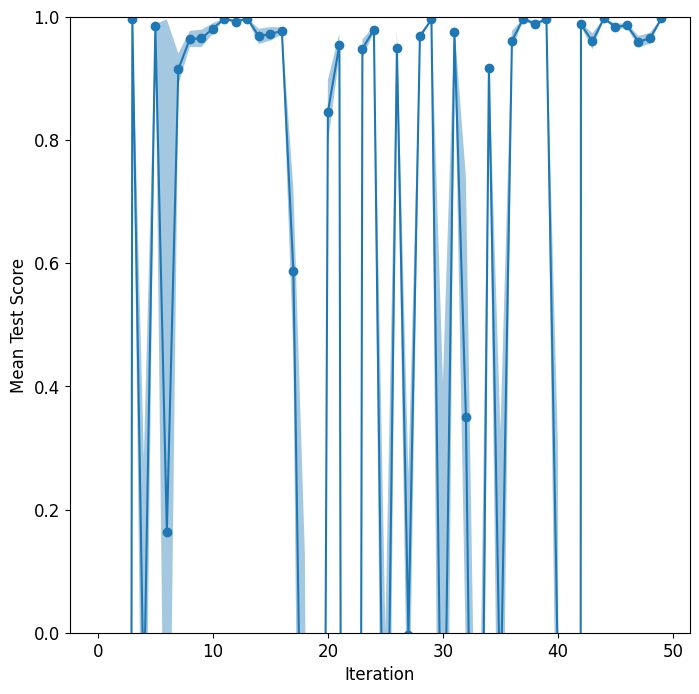

In [11]:
ax = tuner.convergence_plot(model_types="FNN")
ax.set_ylim([0, 1])
plt.show()

The Bayesian search explores the search space but finds several suitable hyperparameter configurations.

## Model Postprocessing

With the models tuned and the top `pyMAISE.Settings.num_configs_saved` saved, we can now pass these models to the `pyMAISE.PostProcessor` for model comparison and analysis. Additionally, we can update some hyperparameters after tuning. For MITR, we changed the number of FNN epochs to 200 since we are only running five models. We give the `pyMAISE.PostProcessor` all the scaled data, the model configurations, the new model settings, and the output scaler.

In [12]:
postprocessor = mai.PostProcessor(
    data=(xtrain, xtest, ytrain, ytest), 
    model_configs=[random_search_configs, bayesian_search_configs], 
    new_model_settings={
        "FNN": {"fitting_params": {"epochs": 200}},
    },
    yscaler=yscaler,
)

We can now evaluate the performance of the models using the `pyMAISE.PostProcessor.metrics` function. This returns an ordered table with training and testing performance metrics. By default, `pyMAISE.PostProcessor.metrics` evaluates the training and testing $R^2$, mean absolute error (MAE), mean absolute percentage error (MAPE), root mean squared error (RMSE), and root mean squared percentage error (RMSPE) for regression problems. The table is sorted by descending testing $R^2$. We can also add additional metrics, sort by a different metric, or choose the output pyMAISE computes the metrics with. Since all outputs are in watts, we do not need to evaluate each output individually. For further functionality on `pyMAISE.PostProcessor.metrics` refer to the [pyMAISE API reference documentation](https://pymaise.readthedocs.io/en/stable/pymaiseapi/index.html).

In [13]:
postprocessor.metrics().drop("Parameter Configurations", axis=1)

,Model Types,Train R2,Train MAE,Train MAPE,Train RMSE,Train RMSPE,Test R2,Test MAE,Test MAPE,Test RMSE,Test RMSPE
62,FNN,0.998592,7.437166,0.038770,10.064732,0.049537,0.998073,8.432762,0.043963,11.691427,0.057808
63,FNN,0.998546,7.926221,0.041372,10.725200,0.051044,0.998020,8.952546,0.046785,12.388387,0.059826
64,FNN,0.998508,7.417174,0.038773,10.334235,0.050746,0.997981,8.341694,0.043538,11.854802,0.058539
65,FNN,0.998358,8.132729,0.042693,11.110705,0.053918,0.997657,9.318658,0.048908,13.100459,0.064297
6,Stacking,0.998476,7.691549,0.040029,10.125429,0.050630,0.997517,9.590908,0.049962,13.140285,0.065097
...,...,...,...,...,...,...,...,...,...,...,...
21,DT,0.873116,74.946516,0.392507,99.068913,0.489806,0.699471,115.763219,0.606771,152.761481,0.753073
25,DT,0.848120,82.562770,0.432506,108.366850,0.536020,0.693812,117.856323,0.617979,153.975932,0.759999
24,DT,0.859494,79.498604,0.416394,104.276376,0.515440,0.693639,117.262489,0.614735,154.187189,0.760875
22,DT,0.847928,82.747855,0.433506,108.649079,0.537079,0.693069,117.919592,0.618165,154.135954,0.760533


This data set is very linear, with fantastic performance from linear and lasso regression. The FNNs proved to be marginally better-performing models over the linear classical models; however, this is at the cost of complexity. K-nearest neighbor, random forest, and decision tree struggled on this data set with all three overfittings.

Using the `pyMAISE.PostProcessor.print_model` function, we can see all the top performing (based on test $R^2$) models' hyperparameters.

In [14]:
for model in ["Lasso", "DT", "FNN", "GP", "RD", "ET", "EN", "GB", "AB", "MultiOutput", "Stacking", "RF", "KN"]:
    postprocessor.print_model(model_type=model)
    print()

Model Type: Lasso
  alpha: 0.0002652151499189426

Model Type: DT
  max_depth: 36
  max_features: 6
  min_samples_leaf: 4
  min_samples_split: 4

Model Type: FNN
  Structural Hyperparameters
    Layer: Dense_hidden_0
      units: 215
      sublayer: None
    Layer: Dense_output_0
  Compile/Fitting Hyperparameters
    Adam_learning_rate: 0.0007074276575343318
    batch_size: 8
Model: "FNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_hidden_0 (Dense)      (None, 215)               1505      
                                                                 
 Dense_output_0 (Dense)      (None, 22)                4752      
                                                                 
Total params: 6257 (24.44 KB)
Trainable params: 6257 (24.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Model Type: GP
  alpha: 1.0029970887197695e-09

Additionally, we can visualize the structure of the FNN using `pyMAISE.PostProcessor.nn_network_plot`. 

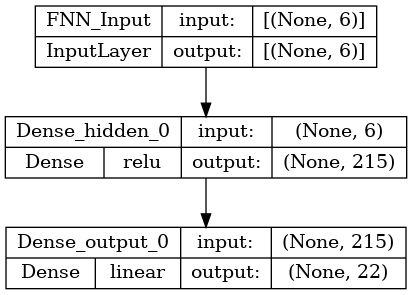

In [15]:
postprocessor.nn_network_plot(
    to_file="./supporting/mit_reactor_network.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    show_layer_activations=True,
)

We can use the `pyMAISE.PostProcessor.diagonal_validation_plot` and `pyMAISE.PostProcessor.validation_plot` functions to visualize the performance of these models. Diagonal validation plots show the actual versus predicted outcome. A well-performing model follows $y=x$ on this plot. You can choose what outputs to display on the diagonal validation plot; however, since all outputs have the same units, we can display all of them. Both functions use the top-performing model on test $R^2$ by default.

In [1]:
models = np.array([["Linear", "Lasso"], ["RD", "FNN"], ["GP", "RD"], ["EN", "ET"], ["AB", "MultiOutput"], ["Stacking", "GB"], ["RF", "KN"]] )
fig, axarr = plt.subplots(models.shape[0], models.shape[1], sharex=True, sharey=True, figsize=(15,40))
for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        plt.sca(axarr[i, j])
        axarr[i, j] = postprocessor.diagonal_validation_plot(model_type=models[i, j])
        axarr[i, j].set_title(models[i, j])

plt.show()

NameError: name 'np' is not defined

All models display a close spread to $y=x$; however, the lack of performance of the decision tree, random forest, and k-nearest neighbor is apparent, given the more extensive spread.

Validation plots show the absolute error of the predicted output relative to the actual outputs of the testing data set. The function can evaluate all output or show just what is given in a list. This list can include column positions in the data set or the output names. Only the A-2, B-8, and C-8 fuel elements are shown for the validation plot below.

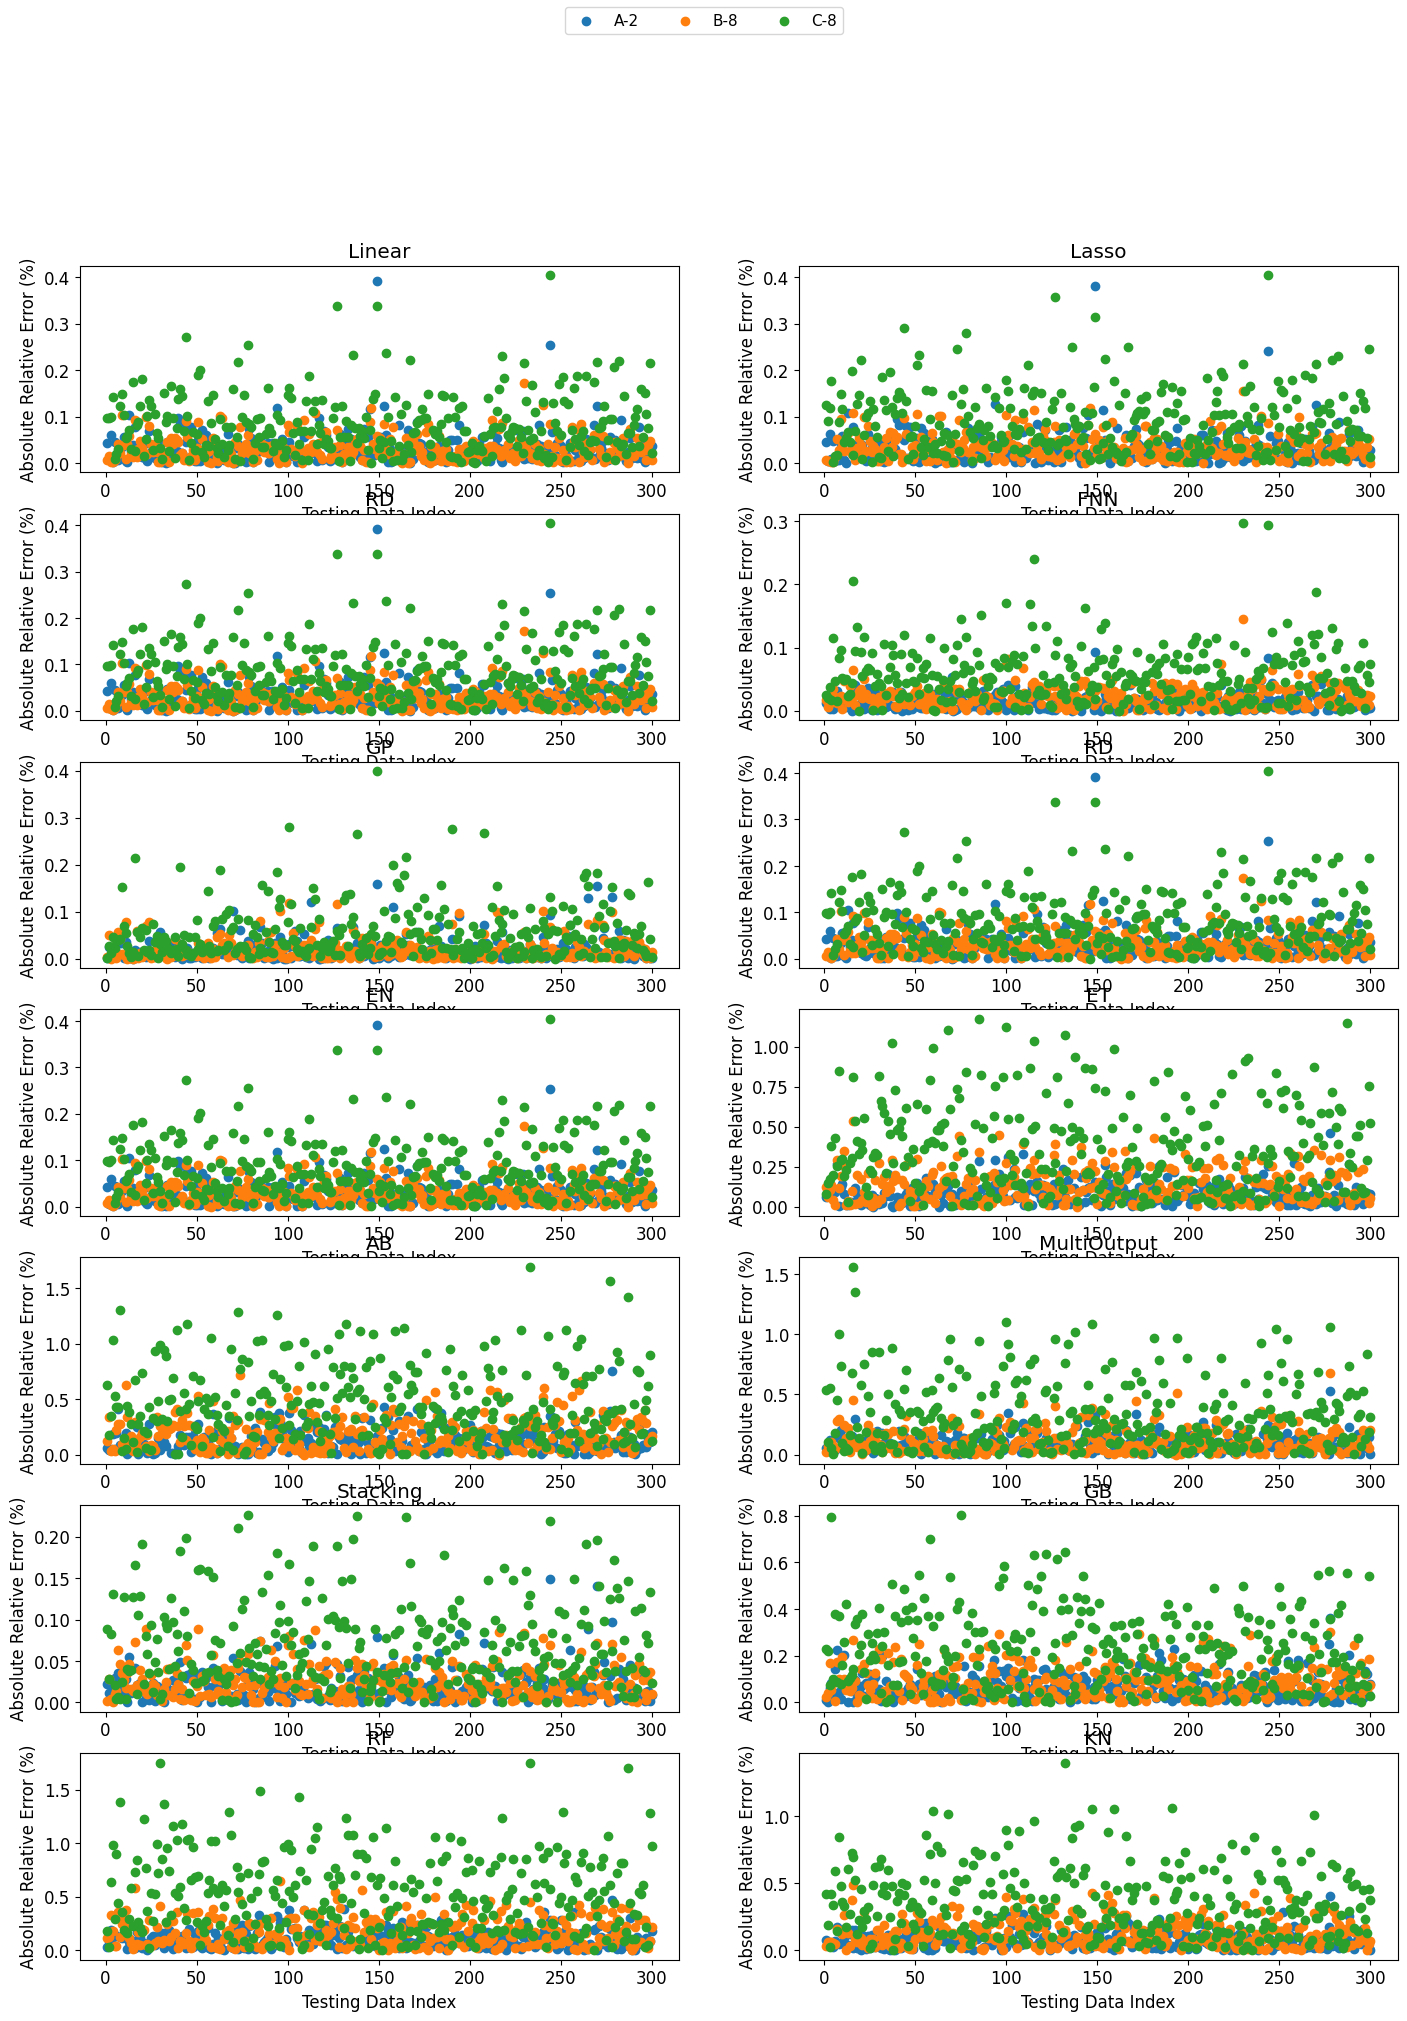

In [17]:
fig, axarr = plt.subplots(models.shape[0], models.shape[1], figsize=(17,22))

y = ["A-2", "B-8", "C-8"]

for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        plt.sca(axarr[i, j])
        axarr[i, j] = postprocessor.validation_plot(model_type=models[i, j], y=y)
        axarr[i, j].set_title(models[i, j])
        axarr[i, j].get_legend().remove()

fig.legend(y, loc="upper center", ncol=4)
plt.show()

The diagonal validation and validation plots agree with the performance metrics. Interestingly, all models increase prediction error as we move radially from the middle of the core.

To further understand the behavior of the top neural network configurations, we can plot the learning curve. Here, the top neural network learning curve is shown but, similar to the diagonal and validation plot functions, `pyMAISE.PostProcessor.nn_learning_plot` shows the neural network based on the index in `pyMAISE.PostProcessor.metrics` or, if no index is provided, the one with the best test $R^2$.

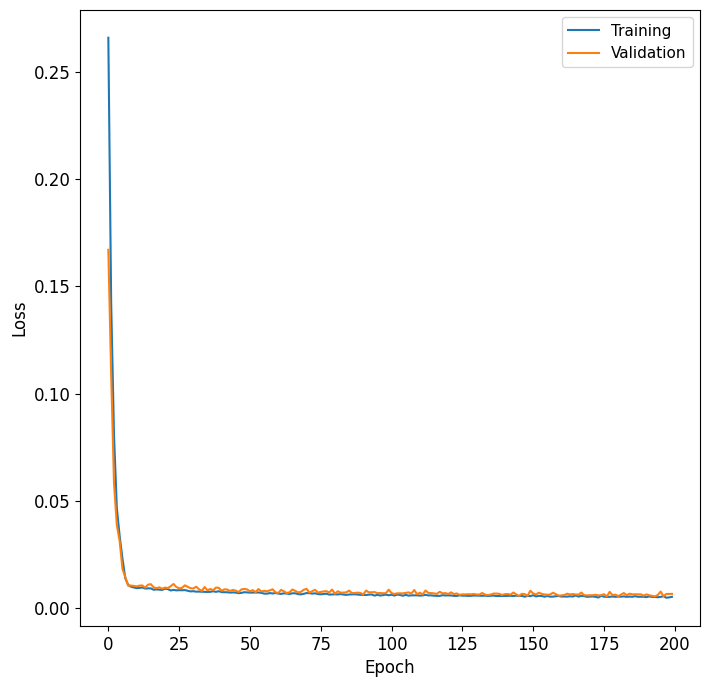

In [18]:
postprocessor.nn_learning_plot()
plt.show()

The FNN is not overfitting, as the validation curve closely follows the training curve.

Finally, using the best FNN model, we can generate a predicted power for each fuel element given the control blade heights. This code block retrieves the top-performing model using the `pyMAISE.PostProcessor.get_model` function.

1/1 [==============================] - 0s 21ms/step


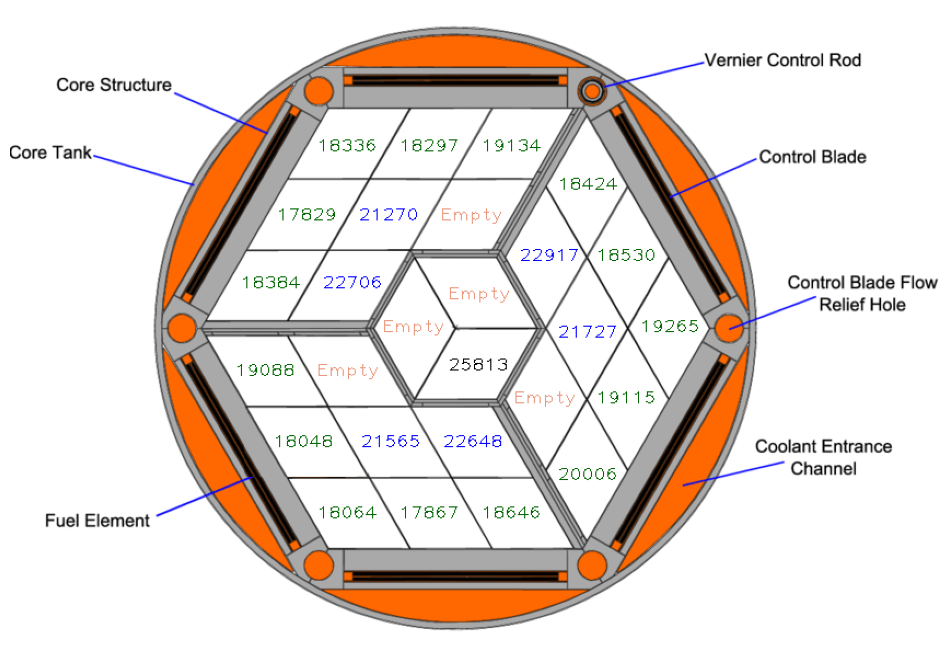

In [19]:
def plot_mitr(model, x, yscaler=None):
    pos=[(400,330), (465,230), (500,300), (395,400), (320,400), (285,255), (318,193),
         (500,165), (535,230), (575,295), (535,360), (500,430), (430,465), (355,465), 
         (280,465), (240,400), (205,335), (210,255), (243,193), (280,130), (355,130), 
         (430,130), (393,193), (460,360), (280,335), (400,265), (340,295)]
    
    Ynn=model.predict(np.array([x,]))
    if yscaler:
        Ynn=yscaler.inverse_transform(Ynn)
    Ynn=Ynn.flatten().tolist()
    
    image = cv2.imread("./supporting/mitr.png")
    for i in range(len(pos)):
        if i==0:
            image=cv2.putText(
                img=np.copy(image), 
                text=str(int(Ynn[i])), 
                org=pos[i], 
                fontFace=1, 
                fontScale=1.1, 
                color=(0,0,0)
            )
        if i in [1,2,3,4,5,6]:
            image=cv2.putText(
                img=np.copy(image), 
                text=str(int(Ynn[i])), 
                org=pos[i], 
                fontFace=1, 
                fontScale=1.1, 
                color=(0,0,255)
            ) 
        if i in list(range(7,22)):
            image=cv2.putText(
                img=np.copy(image), 
                text=str(int(Ynn[i])), 
                org=pos[i], 
                fontFace=1, 
                fontScale=1.1, 
                color=(0, 100, 0)
            ) 
        if i in list(range(22,28)):
            image=cv2.putText(
                img=np.copy(image), 
                text=str('Empty'), 
                org=pos[i], 
                fontFace=1, 
                fontScale=1.1, 
                color=(233, 150, 122)
            )            
    plt.figure(figsize=(12, 12))
    plt.imshow(image)
    plt.axis('off')

x=[0.75266553, 0.90280633, 0.00539489, 0.25308624, 0.57678792, 0.77792903]

plot_mitr(postprocessor.get_model(), x, yscaler)

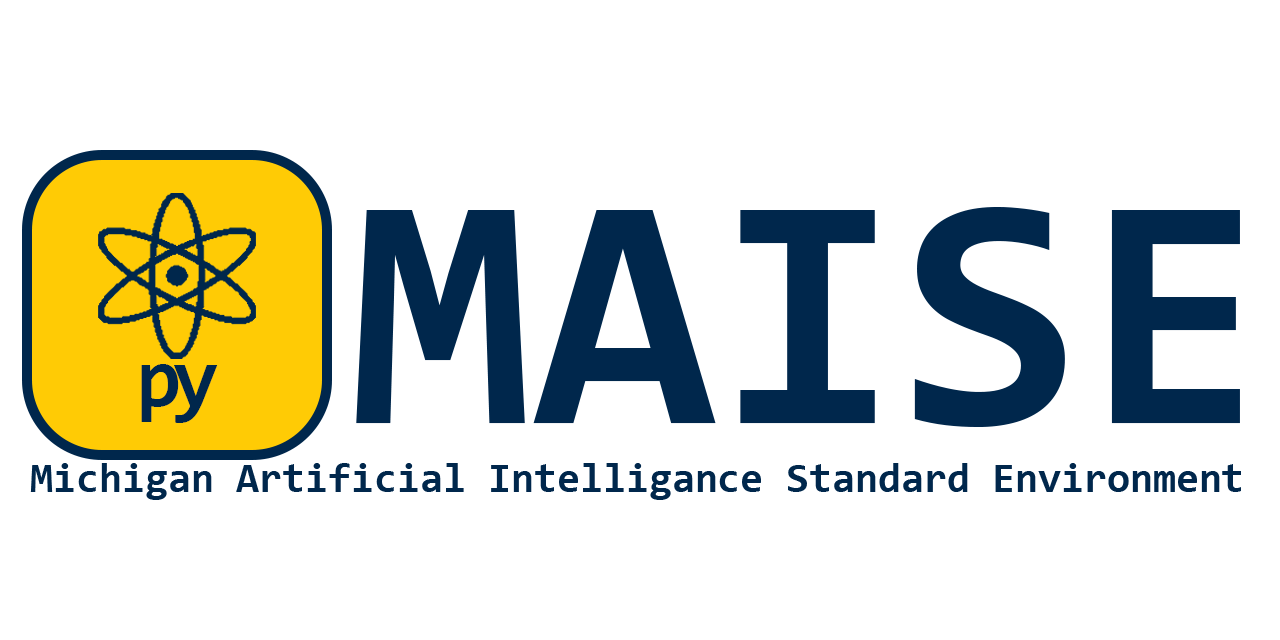